## Loading Dataset, Importing Libraries, Data Cleaning & Preprocessing, and Statistical Summary

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

file_path = 'Machine Downtime.csv'
df = pd.read_csv(file_path)

print(df.head())
print(df.describe())
print(df.info())

missing_values = df.isnull().sum()
print("\nMissing Values:")
print(missing_values)


df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')


duplicates = df.duplicated().sum()
print("\nNumber of duplicate rows:", duplicates)


if duplicates > 0:
    df = df.drop_duplicates()


summary_stats = df.describe()
print("\nSummary Statistics:")
print(summary_stats)


         Date            Machine_ID Assembly_Line_No  Hydraulic_Pressure(bar)  \
0  31-12-2021  Makino-L1-Unit1-2013     Shopfloor-L1                    71.04   
1  31-12-2021  Makino-L1-Unit1-2013     Shopfloor-L1                   125.33   
2  31-12-2021  Makino-L3-Unit1-2015     Shopfloor-L3                    71.12   
3  31-05-2022  Makino-L2-Unit1-2015     Shopfloor-L2                   139.34   
4  31-03-2022  Makino-L1-Unit1-2013     Shopfloor-L1                    60.51   

   Coolant_Pressure(bar)  Air_System_Pressure(bar)  Coolant_Temperature  \
0               6.933725                  6.284965                 25.6   
1               4.936892                  6.196733                 35.3   
2               6.839413                  6.655448                 13.1   
3               4.574382                  6.560394                 24.4   
4               6.893182                  6.141238                  4.1   

   Hydraulic_Oil_Temperature(°C)  Spindle_Bearing_Temperature(

MY COMMENTS:
Based on this initial analysis, we can see that we have a dataset related to machine performance and downtime. The data includes various measurements such as hydraulic pressure, coolant pressure, temperatures, vibrations, and other machine-related metrics. The 'Downtime' column appears to be categorical, indicating whether there was a machine failure or not.

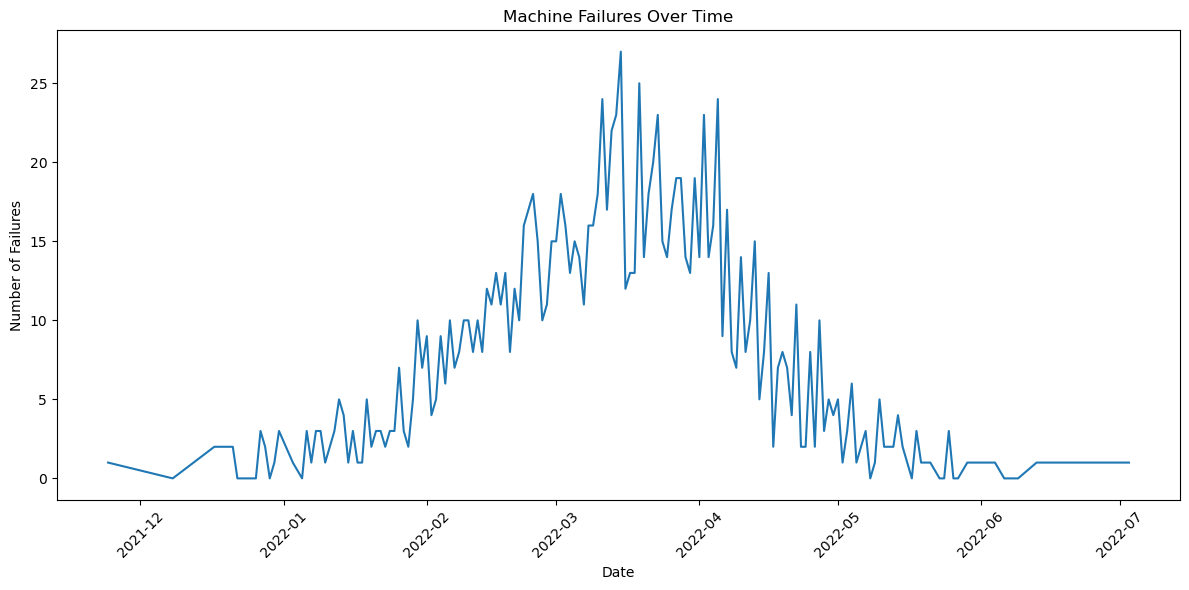

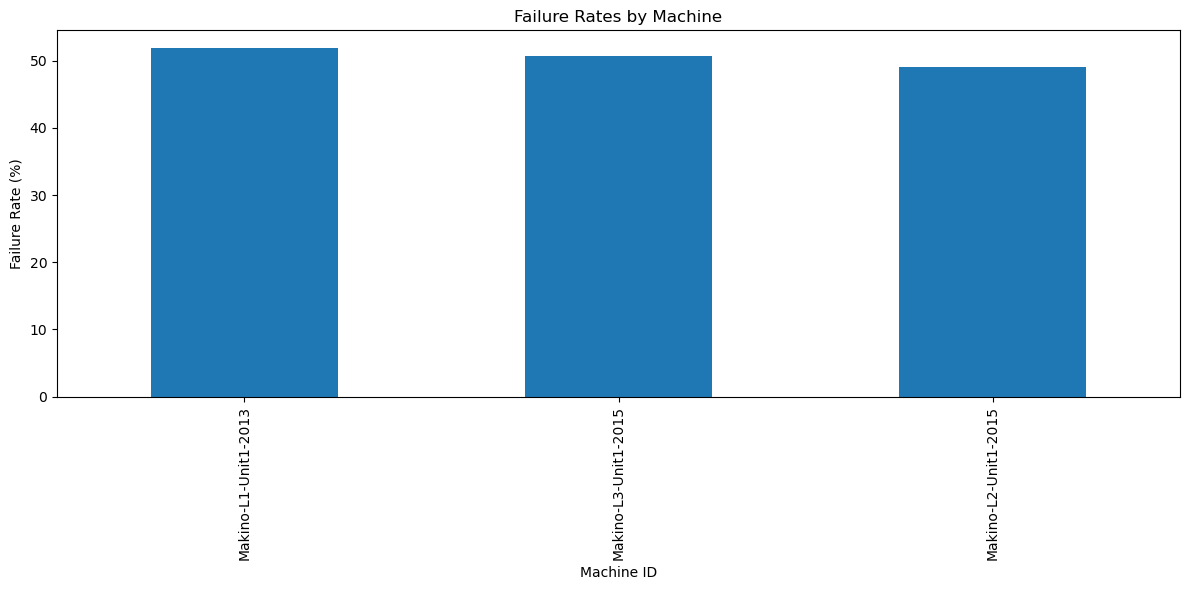

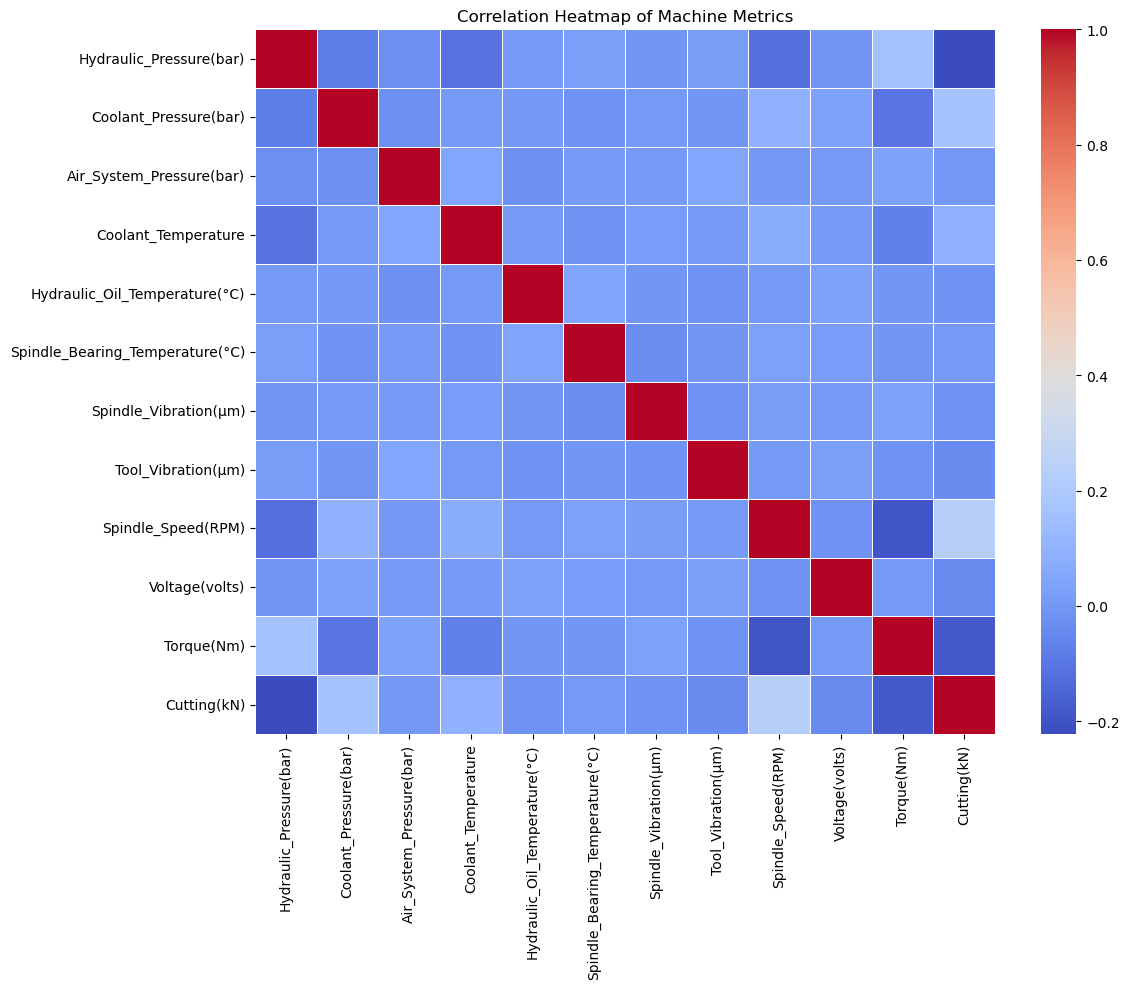

Percentage of machine failures: 50.60%
Top 5 machines with highest failure rates:Machine_ID
Makino-L1-Unit1-2013    51.945080
Makino-L3-Unit1-2015    50.733496
Makino-L2-Unit1-2015    49.009901
Name: Downtime, dtype: float64


In [4]:

# percentage of machine failures
failure_percentage = (df['Downtime'] == 'Machine_Failure').mean() * 100

#time series of machine failures
failures_over_time = df.groupby('Date')['Downtime'].apply(lambda x: (x == 'Machine_Failure').sum()).reset_index()
failures_over_time.columns = ['Date', 'Failure_Count']

# Plot failures over time
plt.figure(figsize=(12, 6))
plt.plot(failures_over_time['Date'], failures_over_time['Failure_Count'])
plt.title('Machine Failures Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Failures')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('failures_over_time.png')
plt.show()

#failure rates by machine
failure_rates = df.groupby('Machine_ID')['Downtime'].apply(lambda x: (x == 'Machine_Failure').mean() * 100).sort_values(ascending=False)

# Plot failure rates by machine
plt.figure(figsize=(12, 6))
failure_rates.plot(kind='bar')
plt.title('Failure Rates by Machine')
plt.xlabel('Machine ID')
plt.ylabel('Failure Rate (%)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('failure_rates_by_machine.png')
plt.show()

#correlation matrix
correlation_matrix = df.drop(['Date', 'Machine_ID', 'Assembly_Line_No', 'Downtime'], axis=1).corr()

#correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Machine Metrics')
plt.tight_layout()
plt.savefig('correlation_heatmap.png')
plt.show()

print(f'Percentage of machine failures: {failure_percentage:.2f}%')
print(f'\
Top 5 machines with highest failure rates:\
{failure_rates.head()}')


### let's analyze the main causes of machine failures and identify any patterns or correlations. 


Downtime
Machine_Failure       1265
No_Machine_Failure    1235
Name: count, dtype: int64


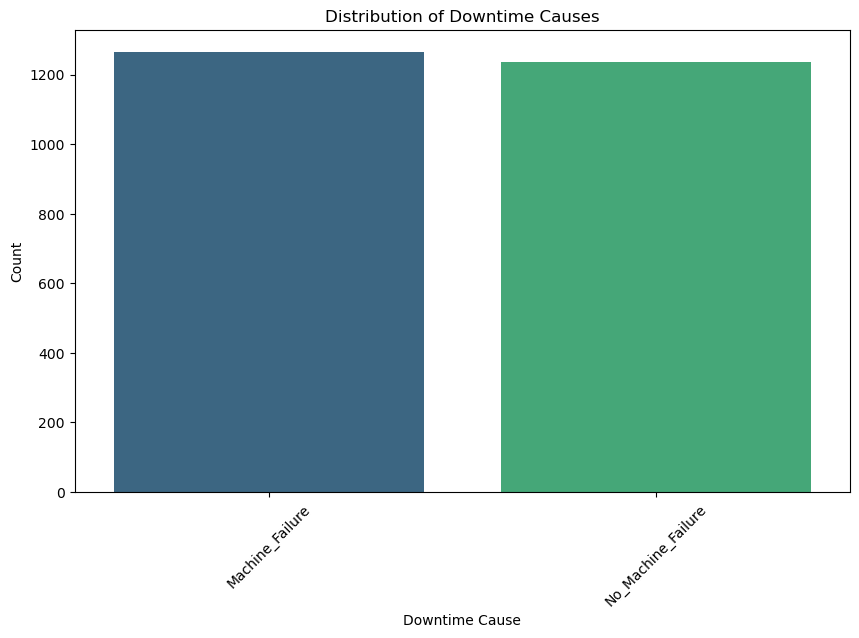

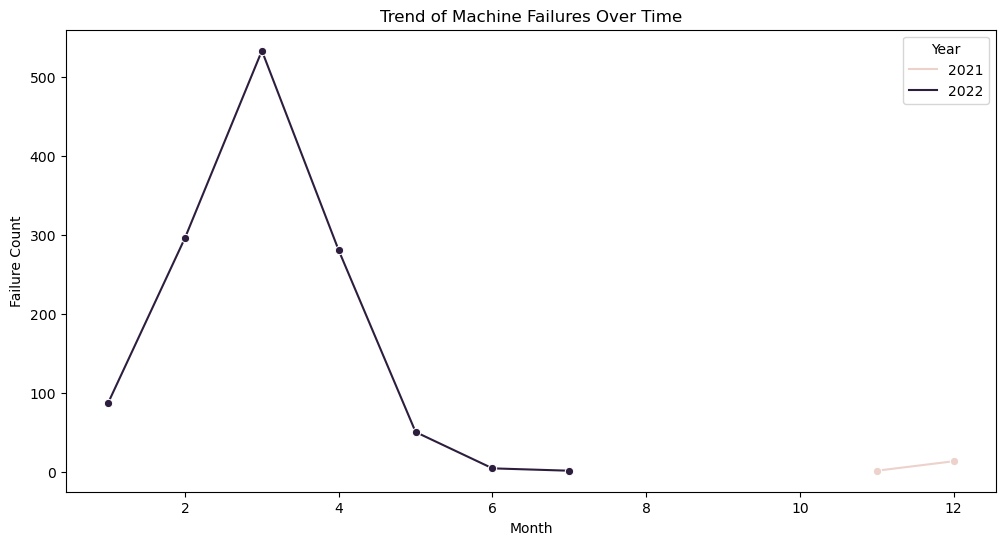

In [6]:

downtime_counts = df['Downtime'].value_counts()
print(downtime_counts)

plt.figure(figsize=(10, 6))
sns.barplot(x=downtime_counts.index, y=downtime_counts.values, palette='viridis')
plt.title('Distribution of Downtime Causes')
plt.xlabel('Downtime Cause')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month


failures_over_time = df[df['Downtime'] == 'Machine_Failure'].groupby(['Year', 'Month']).size().reset_index(name='Failure_Count')


plt.figure(figsize=(12, 6))
sns.lineplot(x='Month', y='Failure_Count', hue='Year', data=failures_over_time, marker='o')
plt.title('Trend of Machine Failures Over Time')
plt.xlabel('Month')
plt.ylabel('Failure Count')
plt.legend(title='Year')
plt.show()


MY COMMENTS:
some initial conclusions:

Machine failures are the primary cause of downtime.

There seems to be some seasonality in machine failures, with certain months showing higher failure rates than others.

The trend of machine failures varies across different years, suggesting that external factors or changes in maintenance practices might influence failure rates.




### correlation between various machine metrics and failure rates.

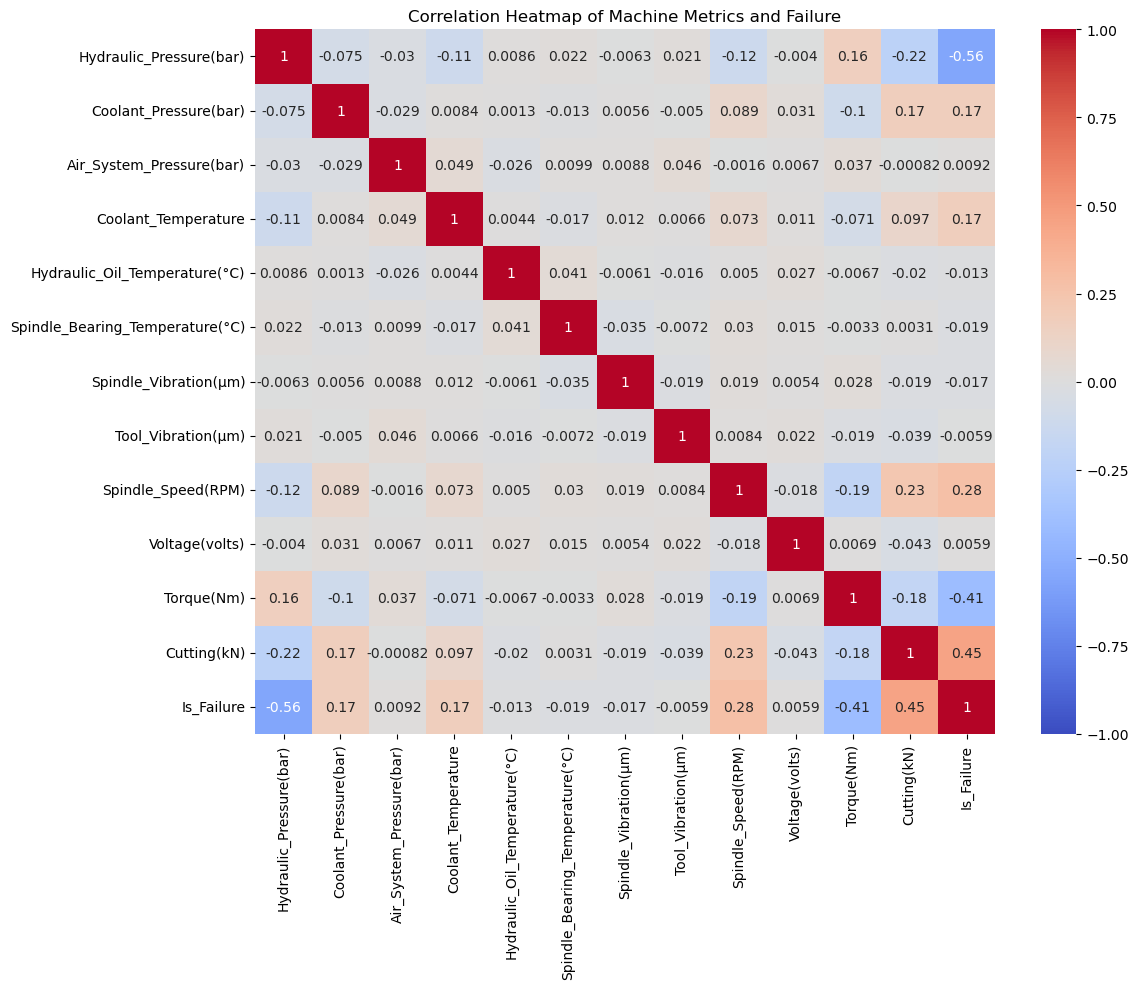

Top 5 metrics correlated with machine failure:
Hydraulic_Pressure(bar)    0.558218
Cutting(kN)                0.450093
Torque(Nm)                 0.408505
Spindle_Speed(RPM)         0.275127
Coolant_Pressure(bar)      0.171678
Name: Is_Failure, dtype: float64


In [10]:
df['Is_Failure'] = (df['Downtime'] == 'Machine_Failure').astype(int)

# Selecting numerical columns for correlation analysis
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
#numeric_columns.remove('Is_Failure')  # Remove the target variable from predictors

#correlation matrix
correlation_matrix = df[numeric_columns + ['Is_Failure']].corr()

#correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap of Machine Metrics and Failure')
plt.tight_layout()
plt.show()

#top 5 metrics with highest absolute correlation to machine failure
top_correlations = correlation_matrix['Is_Failure'].abs().sort_values(ascending=False)[1:6]
print('Top 5 metrics correlated with machine failure:')
print(top_correlations)



MY COMMENTS:
The top 5 metrics most correlated with machine failures are:

Hydraulic Pressure (bar)
Cutting (kN)
Torque (Nm)
Spindle Speed (RPM)
Coolant Pressure (bar)



## Univariate Analysis, Bivariate Analysis, and time Series Analysis.

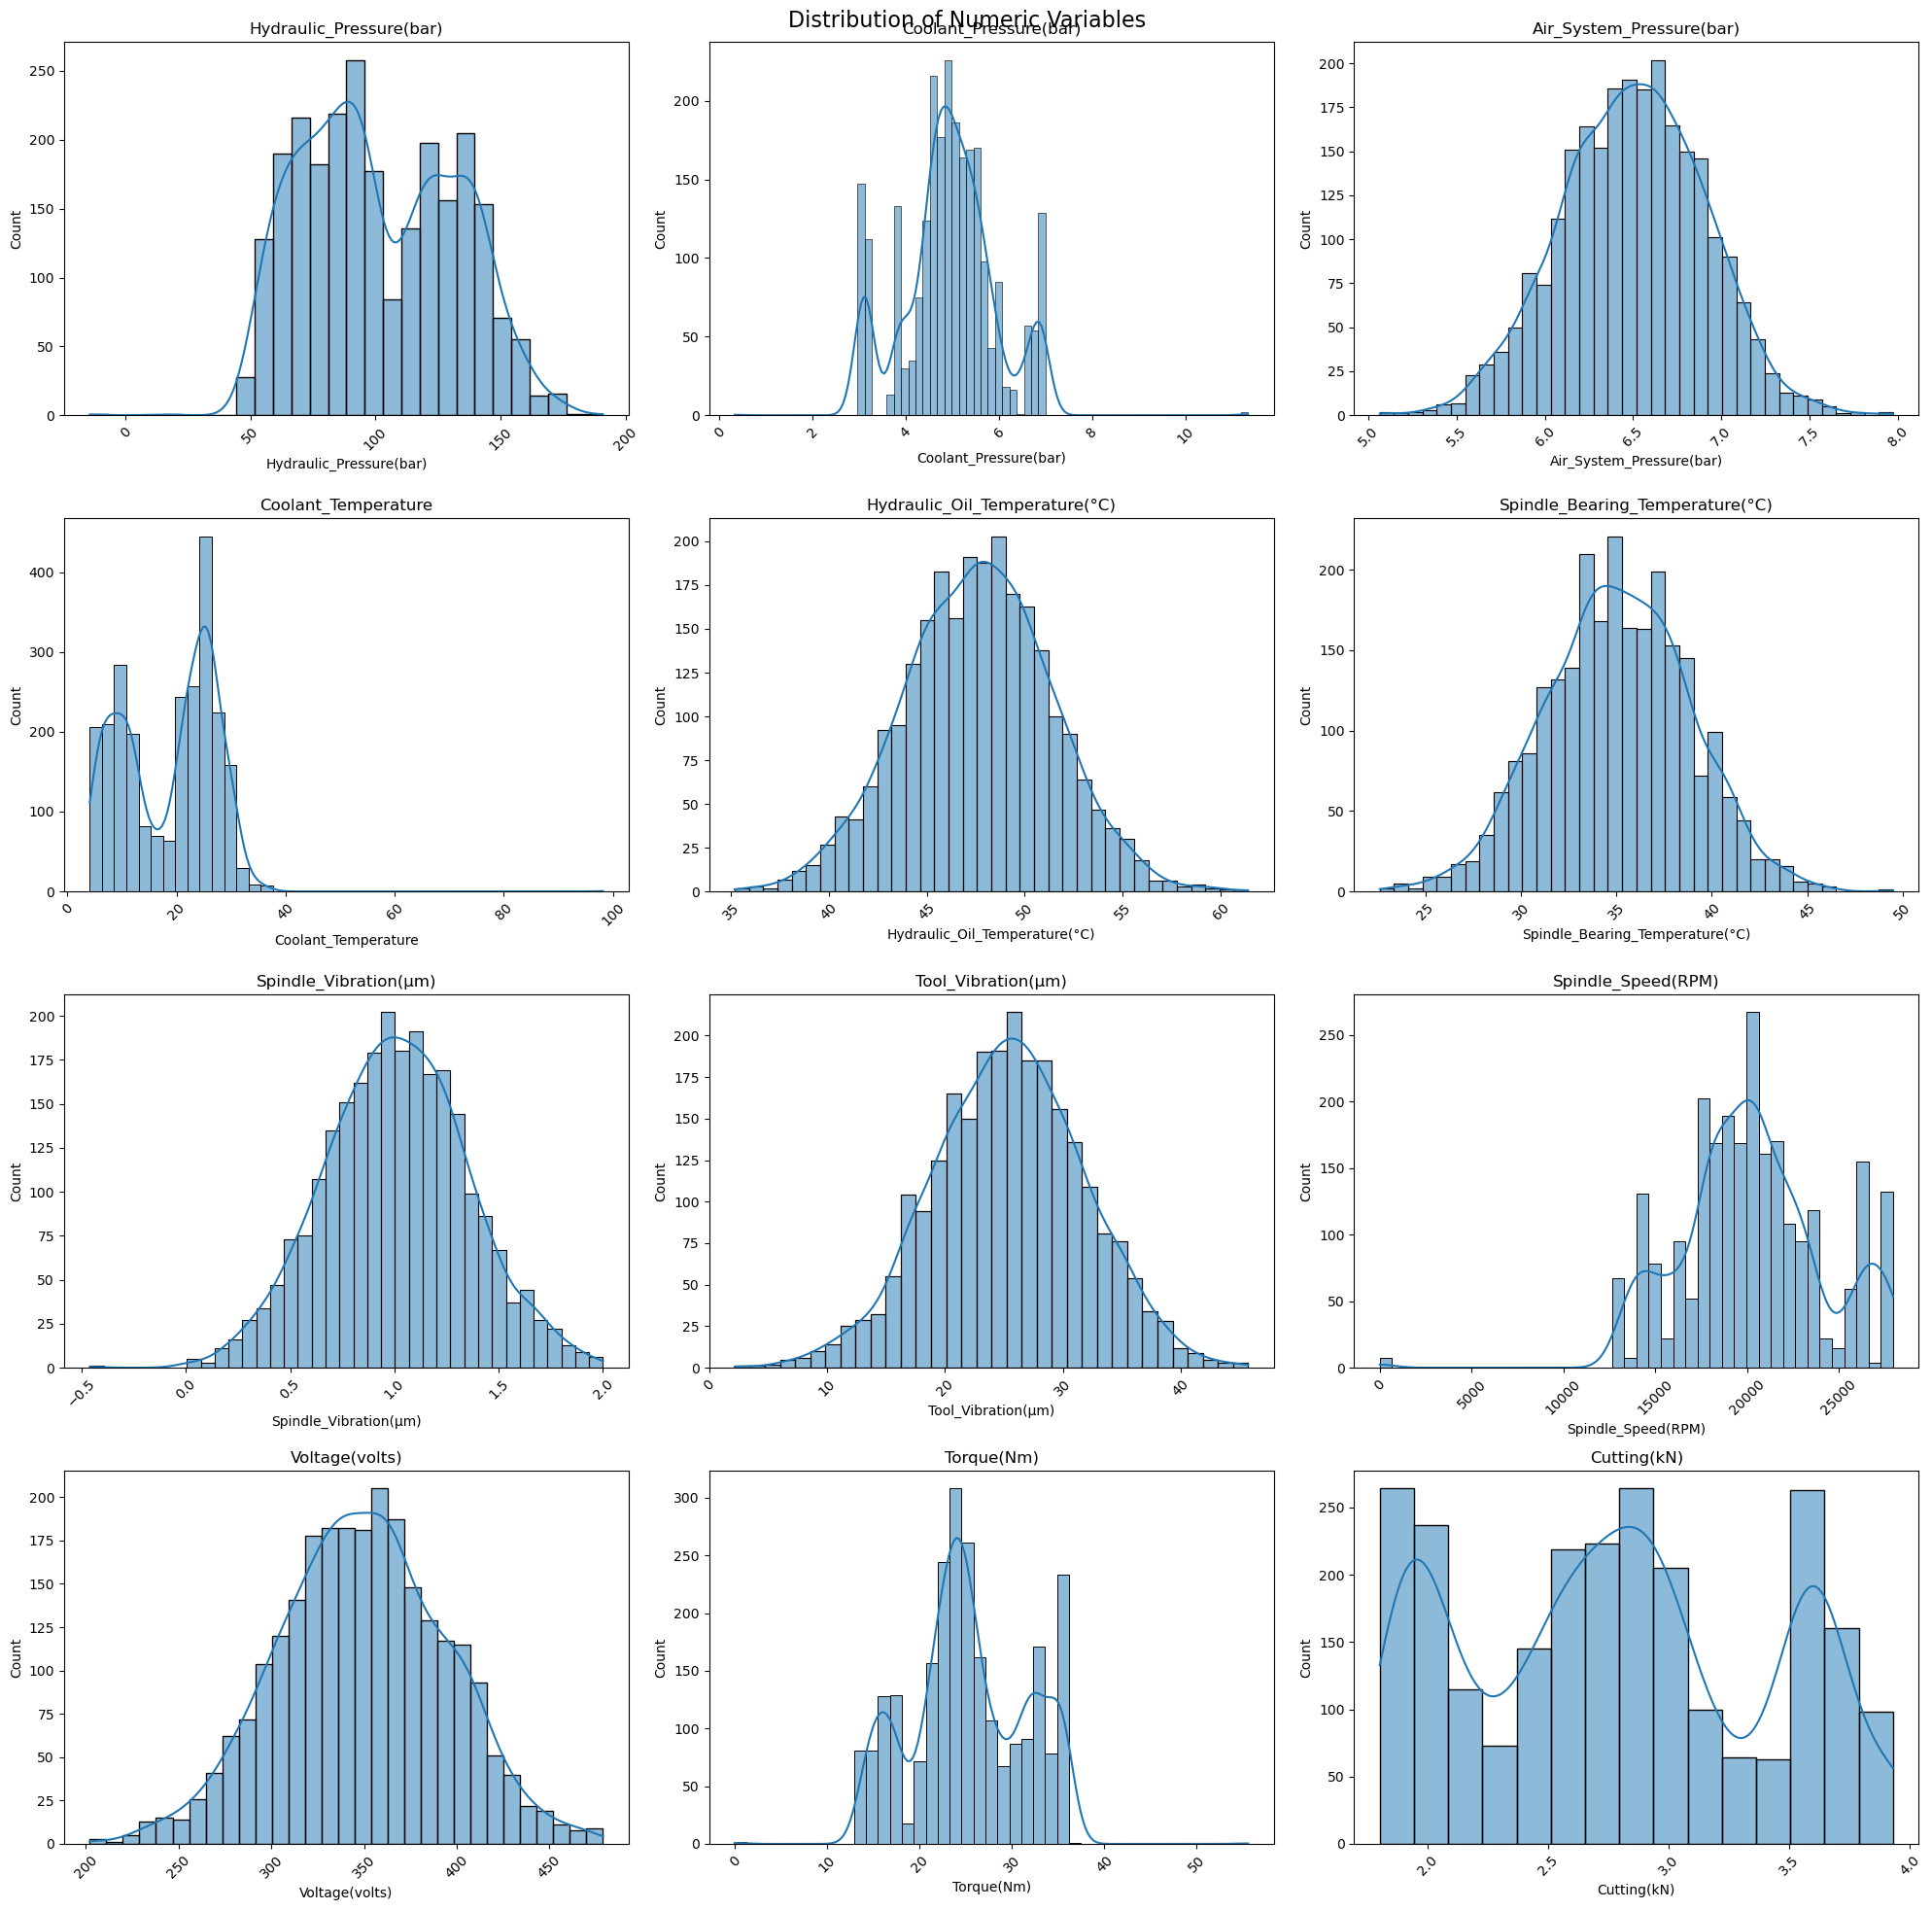

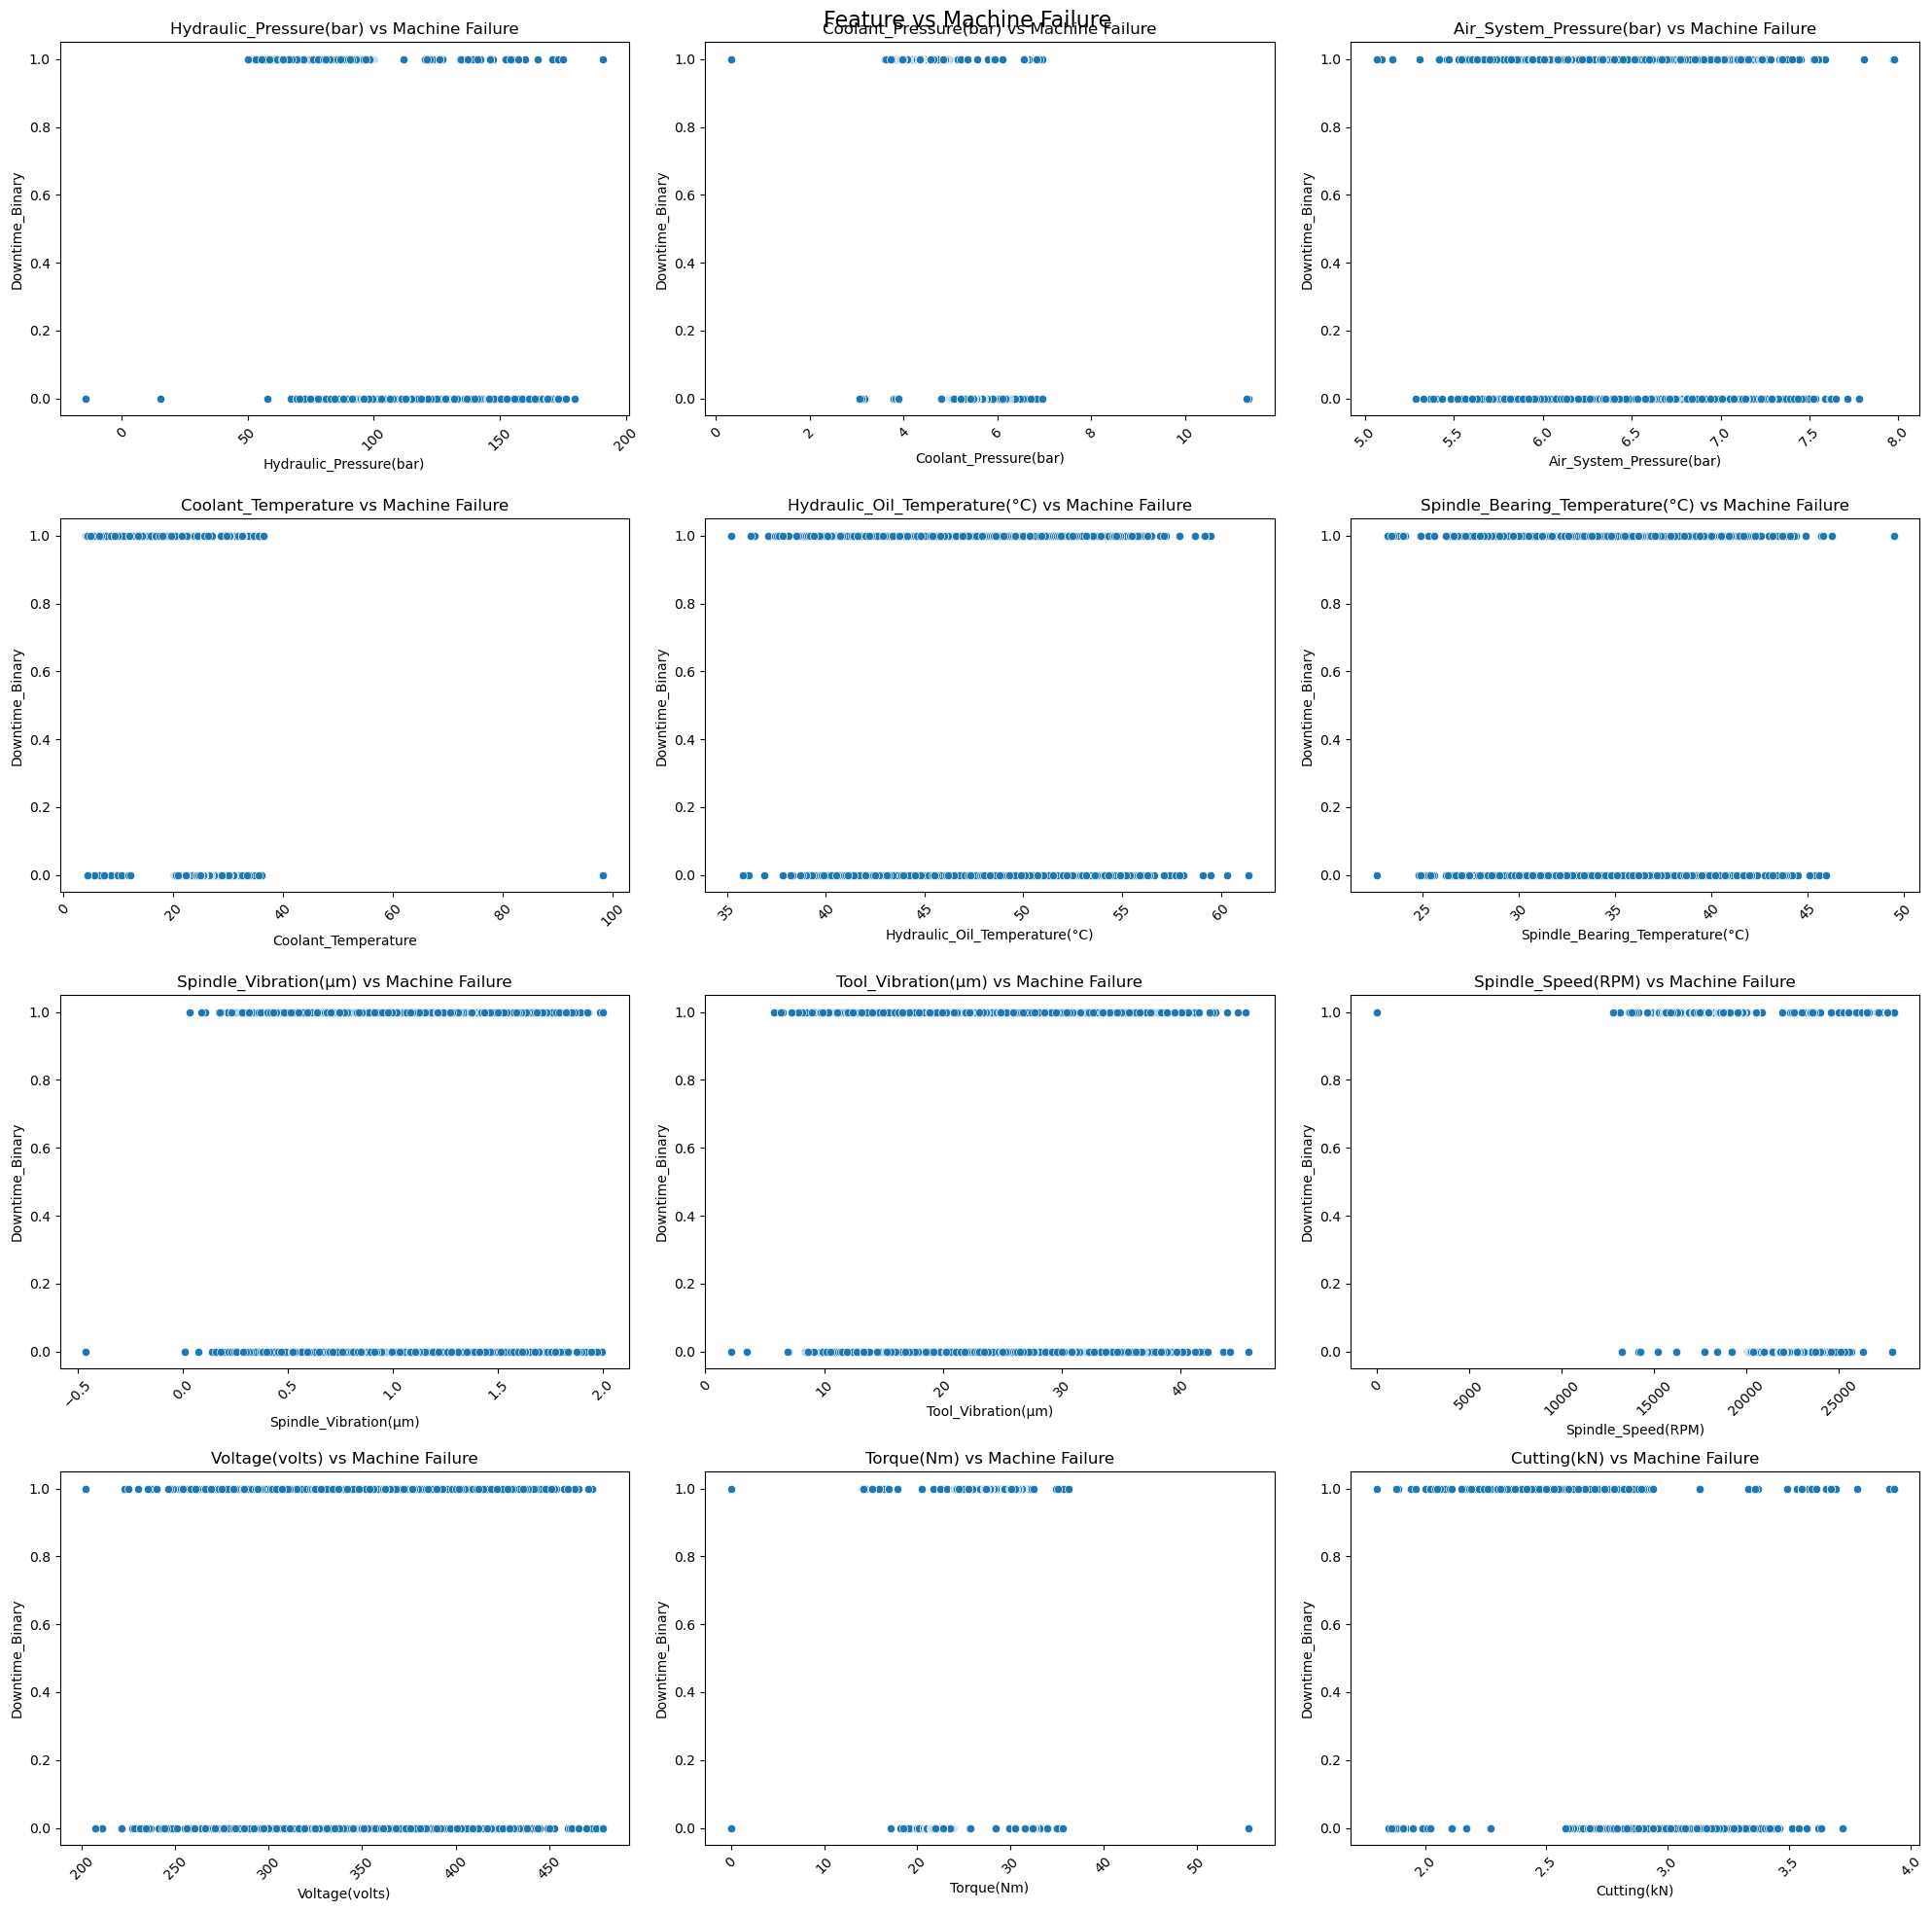

Correlation with Machine Failure:
Downtime_Binary                    1.000000
Cutting(kN)                        0.450093
Spindle_Speed(RPM)                 0.275127
Coolant_Pressure(bar)              0.171678
Coolant_Temperature                0.169235
Air_System_Pressure(bar)           0.009213
Voltage(volts)                     0.005853
Tool_Vibration(µm)                -0.005889
Hydraulic_Oil_Temperature(°C)     -0.012647
Spindle_Vibration(µm)             -0.016665
Spindle_Bearing_Temperature(°C)   -0.019472
Torque(Nm)                        -0.408505
Hydraulic_Pressure(bar)           -0.558218
Name: Downtime_Binary, dtype: float64


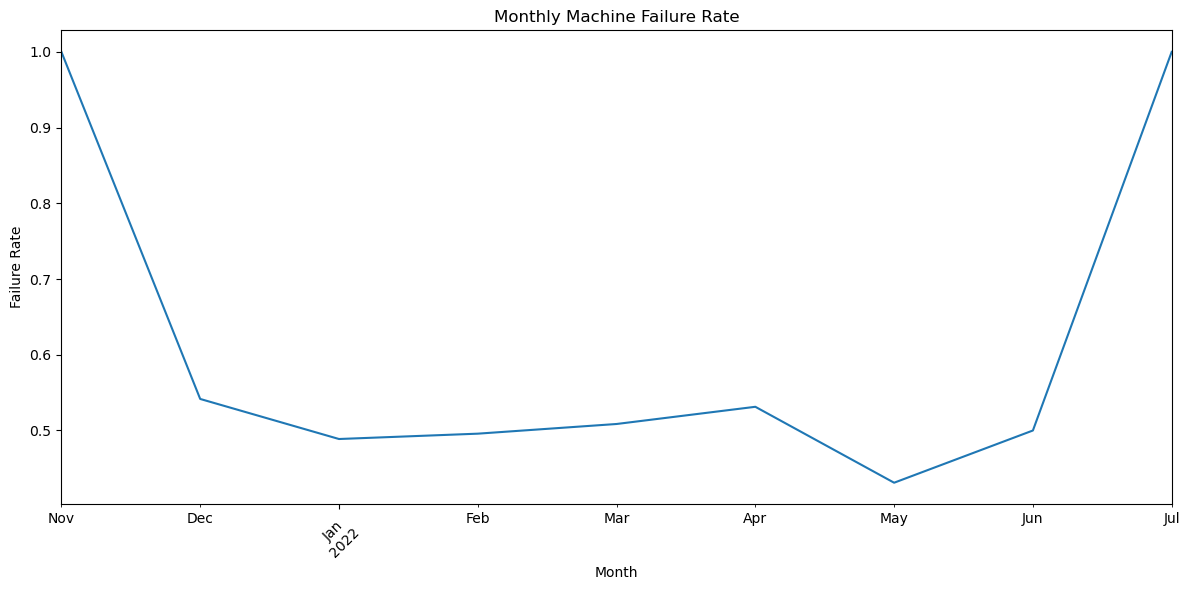

In [25]:
from scipy import stats
fig, axes = plt.subplots(4, 3, figsize=(20, 20))
fig.suptitle('Distribution of Numeric Variables', fontsize=16)
axes = axes.ravel()

for i, col in enumerate(numeric_columns):
    sns.histplot(df[col], kde=True, ax=axes[i])
    axes[i].set_title(col)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Bivariate analysis
# Scatter plots of each feature vs Downtime_Binary
fig, axes = plt.subplots(4, 3, figsize=(20, 20))
fig.suptitle('Feature vs Machine Failure', fontsize=16)
axes = axes.ravel()

df['Downtime_Binary'] = df['Downtime'].apply(lambda x: 1 if x == 'Machine_Failure' else 0)

for i, col in enumerate(numeric_columns):
    sns.scatterplot(data=df, x=col, y='Downtime_Binary', ax=axes[i])
    axes[i].set_title(f'{col} vs Machine Failure')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Calculate correlation with target variable
correlation_with_target = df[numeric_columns + ['Downtime_Binary']].corr()['Downtime_Binary'].sort_values(ascending=False)

print('Correlation with Machine Failure:')
print(correlation_with_target)


# Time series analysis
df['Month'] = df['Date'].dt.to_period('M')
monthly_failures = df.groupby('Month')['Downtime_Binary'].mean()

plt.figure(figsize=(12, 6))
monthly_failures.plot()
plt.title('Monthly Machine Failure Rate')
plt.xlabel('Month')
plt.ylabel('Failure Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Univariate Analysis:
Some variables like Hydraulic_Pressure(bar) and Torque(Nm) have a wide range of values, while others like Air_System_Pressure(bar) are more narrowly distributed.

Bivariate Analysis:
The scatter plots reveal the relationship between each feature and machine failure. For instance, Cutting(kN) and Spindle_Speed(RPM) show a noticeable pattern with machine failures.

Correlation with Machine Failure:
Cutting(kN) and Spindle_Speed(RPM) have the highest positive correlation with machine failure, indicating that higher values in these features are associated with more frequent failures.
